ResNet50 model to predict the image name

In [ ]:
import tensorflow as tf
from tensorflow  import keras
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.utils import plot_model, to_categorical


from keras.layers import Dense, Conv2D,MaxPooling2D, Dropout, BatchNormalization, Flatten
from keras import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os, sys
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

!pip install visualkeras
import visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 11.0 MB/s eta 0:00:00


In [ ]:
model=ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 6s 0us/step


In [ ]:
image_path='/content/kitty.jpg'

In [ ]:
img=image.load_img(image_path, target_size=(224,224))
img_array=image.img_to_array(img)
img_array=np.expand_dims(img_array, axis=0) # one dim data
img_array=preprocess_input(img_array)


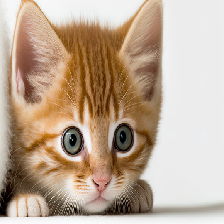

In [ ]:
img

In [ ]:
predicts=model.predict(img_array)
print('predict cat;',decode_predictions(predicts, top=5)[0])

35363/35363 [==============================] - 0s 0us/step
predict cat; [('n02123045', 'tabby', 0.69337404), ('n02123159', 'tiger_cat', 0.14920418), ('n02971356', 'carton', 0.02931623), ('n02124075', 'Egyptian_cat', 0.022729674), ('n04554684', 'washer', 0.016512899)]


In [ ]:
# as we can see usig similar weight , still not giving good result . instead we can train the model with same layers and architechture

In [ ]:
# the above mdoel is pretrained on certain set of imanges not human images. so if human image is give to this model then it predicting wrong


# Cat vs Dogs  Image Classification



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:09<00:00, 42.4MB/s]
100% 1.06G/1.06G [00:09<00:00, 117MB/s] 


In [ ]:
import zipfile

zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
# generate image
train_ds=keras.utils.image_dataset_from_directory( directory= '/content/train',
                                                  labels = "inferred", # how many labels there , cat >0 ..dog>1
                                                   label_mode= "int",
                                                   batch_size = 32,
                                                  image_size = (256, 256))

test_ds=keras.utils.image_dataset_from_directory( directory= '/content/test',
                                                  labels = "inferred", # how many labels there , cat >0 ..dog>1
                                                   label_mode= "int",
                                                   batch_size = 32,
                                                  image_size = (256, 256))

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


#Data normalization

In [ ]:
def process(image, label):
  image=tf.cast(image/255.0, tf.float32)
  return image, label

In [ ]:
train_ds=train_ds.map(process)
test_ds=test_ds.map(process)

In [ ]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Building Alexnet model

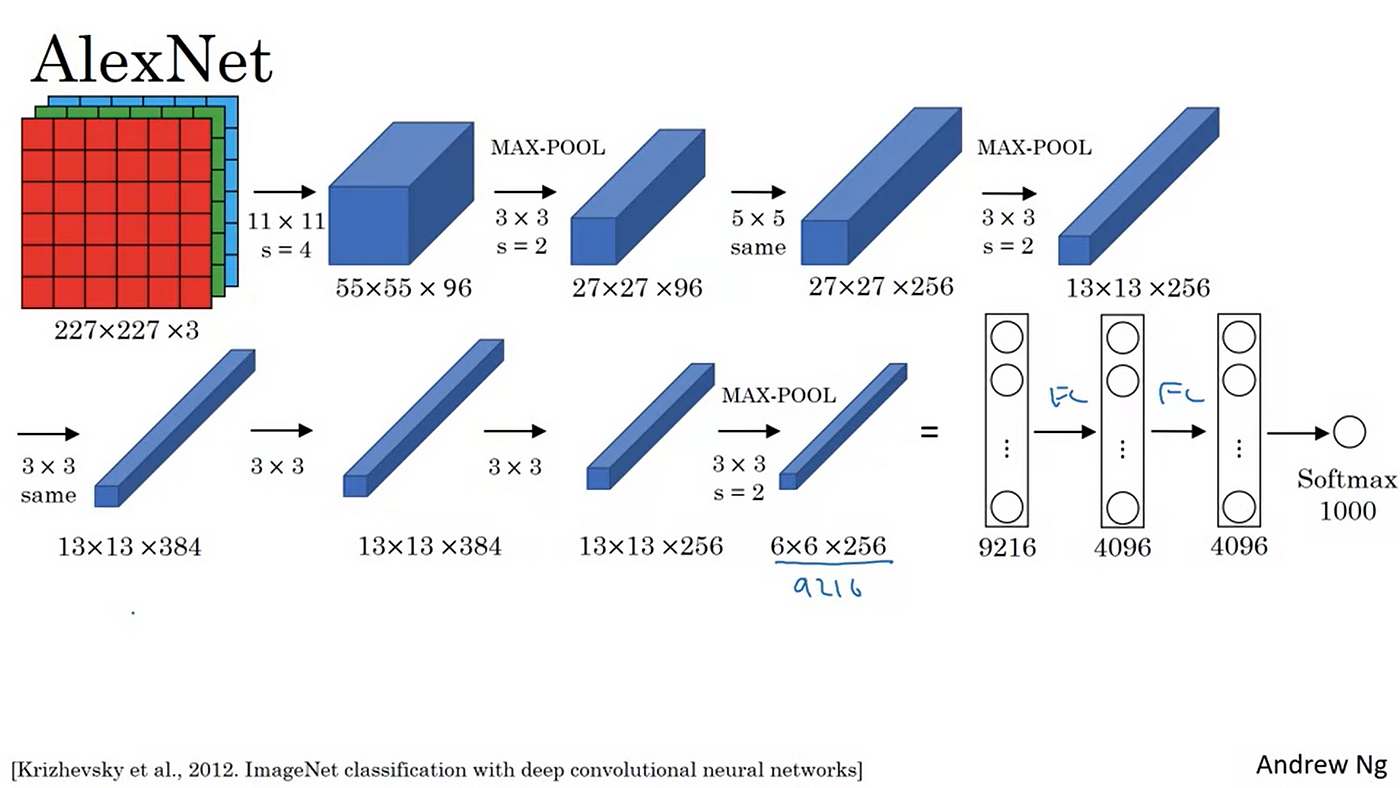

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_5 (Bat  (None, 62, 62, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_6 (Bat  (None, 30, 30, 256)       1024      
 chNormalization)                                                
                                                      

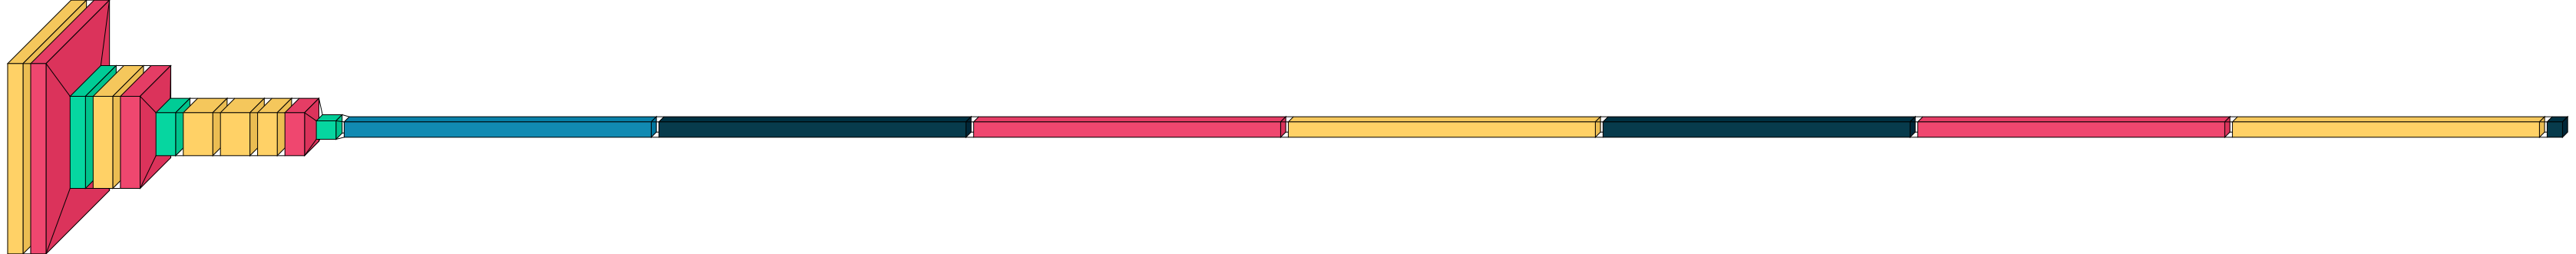

In [ ]:
model1=Sequential()

#Layer1 Conv2D layer with Batch Normalization
model1.add(Conv2D(96, kernel_size=(11,11), padding='valid', strides=4, activation='relu', input_shape=(256,256,3)))
#input is 256*256 , filter is 11*11 > ( (256-11)/4+1)  > output size 62*62
# trainable parameter dependes on the filter size = (11*11*3(3 channel) +1) *96 >>> 34944

model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
#input 62*62 , filter=3*3 , stride=2 >>>output size >(62-3)/2 +1>>>>30*30

#Layer2 Conv2D layer with Batch Normalization
model1.add(Conv2D(256, kernel_size=(5,5), padding='same', strides=1, activation='relu'))
# input 30*30,  kernel> 5*5 , > padding=1 >>> output size same as passing is same  > 30*30
#trainable parameter > (5*5*96+1) *256 > 614656 ( 3 channel not considering as its only applied to input layer)

model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# (30-3)/2 +1  >>> 14*14

#Layer3,4,5 Conv2D layers
model1.add(Conv2D(384, kernel_size=(3,3), padding='same', strides=1, activation='relu'))# same padding 14*14
model1.add(Conv2D(384, kernel_size=(3,3), padding='same', strides=1, activation='relu')) # 14*14
model1.add(Conv2D(256, kernel_size=(3,3), padding='same', strides=1, activation='relu'))# 14*14
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')) # (14-3)/2 +1 >6*6

#Deep Neural Network Layer
model1.add(Flatten()) # 6*6*256 >>>9216
model1.add(Dense(4096, activation='relu')) # 9216*4096+4096>>37752832
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(4096, activation='relu'))# 4096*4096+4096  > 16781312
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid')) #4097

model1.summary()
visualkeras.layered_view(model1)


In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
history1=model1.fit(train_ds, validation_data=(test_ds), batch_size=128, epochs=10)

Epoch 1/10
625/625 [==============================] - 62s 92ms/step - loss: 0.8398 - accuracy: 0.5811 - val_loss: 0.7979 - val_accuracy: 0.5618
Epoch 2/10
625/625 [==============================] - 53s 84ms/step - loss: 0.6913 - accuracy: 0.6446 - val_loss: 0.6864 - val_accuracy: 0.6502
Epoch 3/10
625/625 [==============================] - 51s 81ms/step - loss: 0.6909 - accuracy: 0.6442 - val_loss: 0.8164 - val_accuracy: 0.6232
Epoch 4/10
625/625 [==============================] - 52s 83ms/step - loss: 0.5937 - accuracy: 0.7092 - val_loss: 0.9383 - val_accuracy: 0.5960
Epoch 5/10
625/625 [==============================] - 50s 80ms/step - loss: 0.4915 - accuracy: 0.7721 - val_loss: 0.6406 - val_accuracy: 0.6814
Epoch 6/10
625/625 [==============================] - 54s 85ms/step - loss: 0.4150 - accuracy: 0.8181 - val_loss: 0.4054 - val_accuracy: 0.8330
Epoch 7/10
625/625 [==============================] - 53s 84ms/step - loss: 0.3474 - accuracy: 0.8494 - val_loss: 0.3508 - val_accuracy:

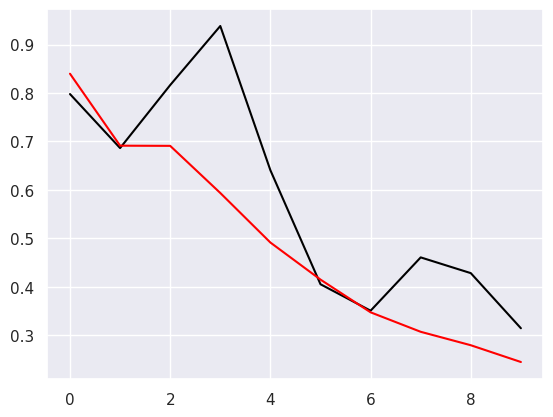

In [ ]:
plt.plot(history1.history['val_loss'], color='black')
plt.plot(history1.history['loss'], color='red')

In [ ]:
image_path='/content/kitty.jpg'
image_pth='/content/Dog_Breeds.jpg'

In [ ]:
img=image.load_img(image_pth, target_size=(256,256))
img_array=image.img_to_array(img)
img_array=np.expand_dims(img_array, axis=0) # one dim data
img_array=preprocess_input(img_array)


1/1 [==============================] - 0s 20ms/step
[[0.]]
predict Dog; cat


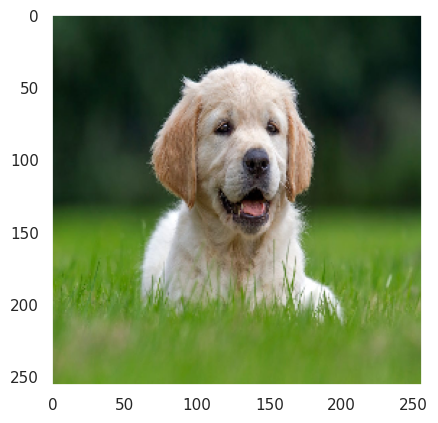

In [ ]:
class_name=['cat', 'dog']

image_index = 5000
plt.imshow(test_ds[image_index].reshape(32, 32,3))
plt.colorbar()
plt.grid(False)
plt.show()
pred = model.predict(test_images[image_index].reshape(1, 32, 32, 3))
print('Predicted Class',class_name[pred.argmax()])
print('Actual Class',class_name[test_labels[image_index]] )


In [ ]:

pred=model.predict(img_array)
print(predicts)
plt.imshow(img)
plt.grid(False)
print('predict Dog;',class_name[pred.argmax()])


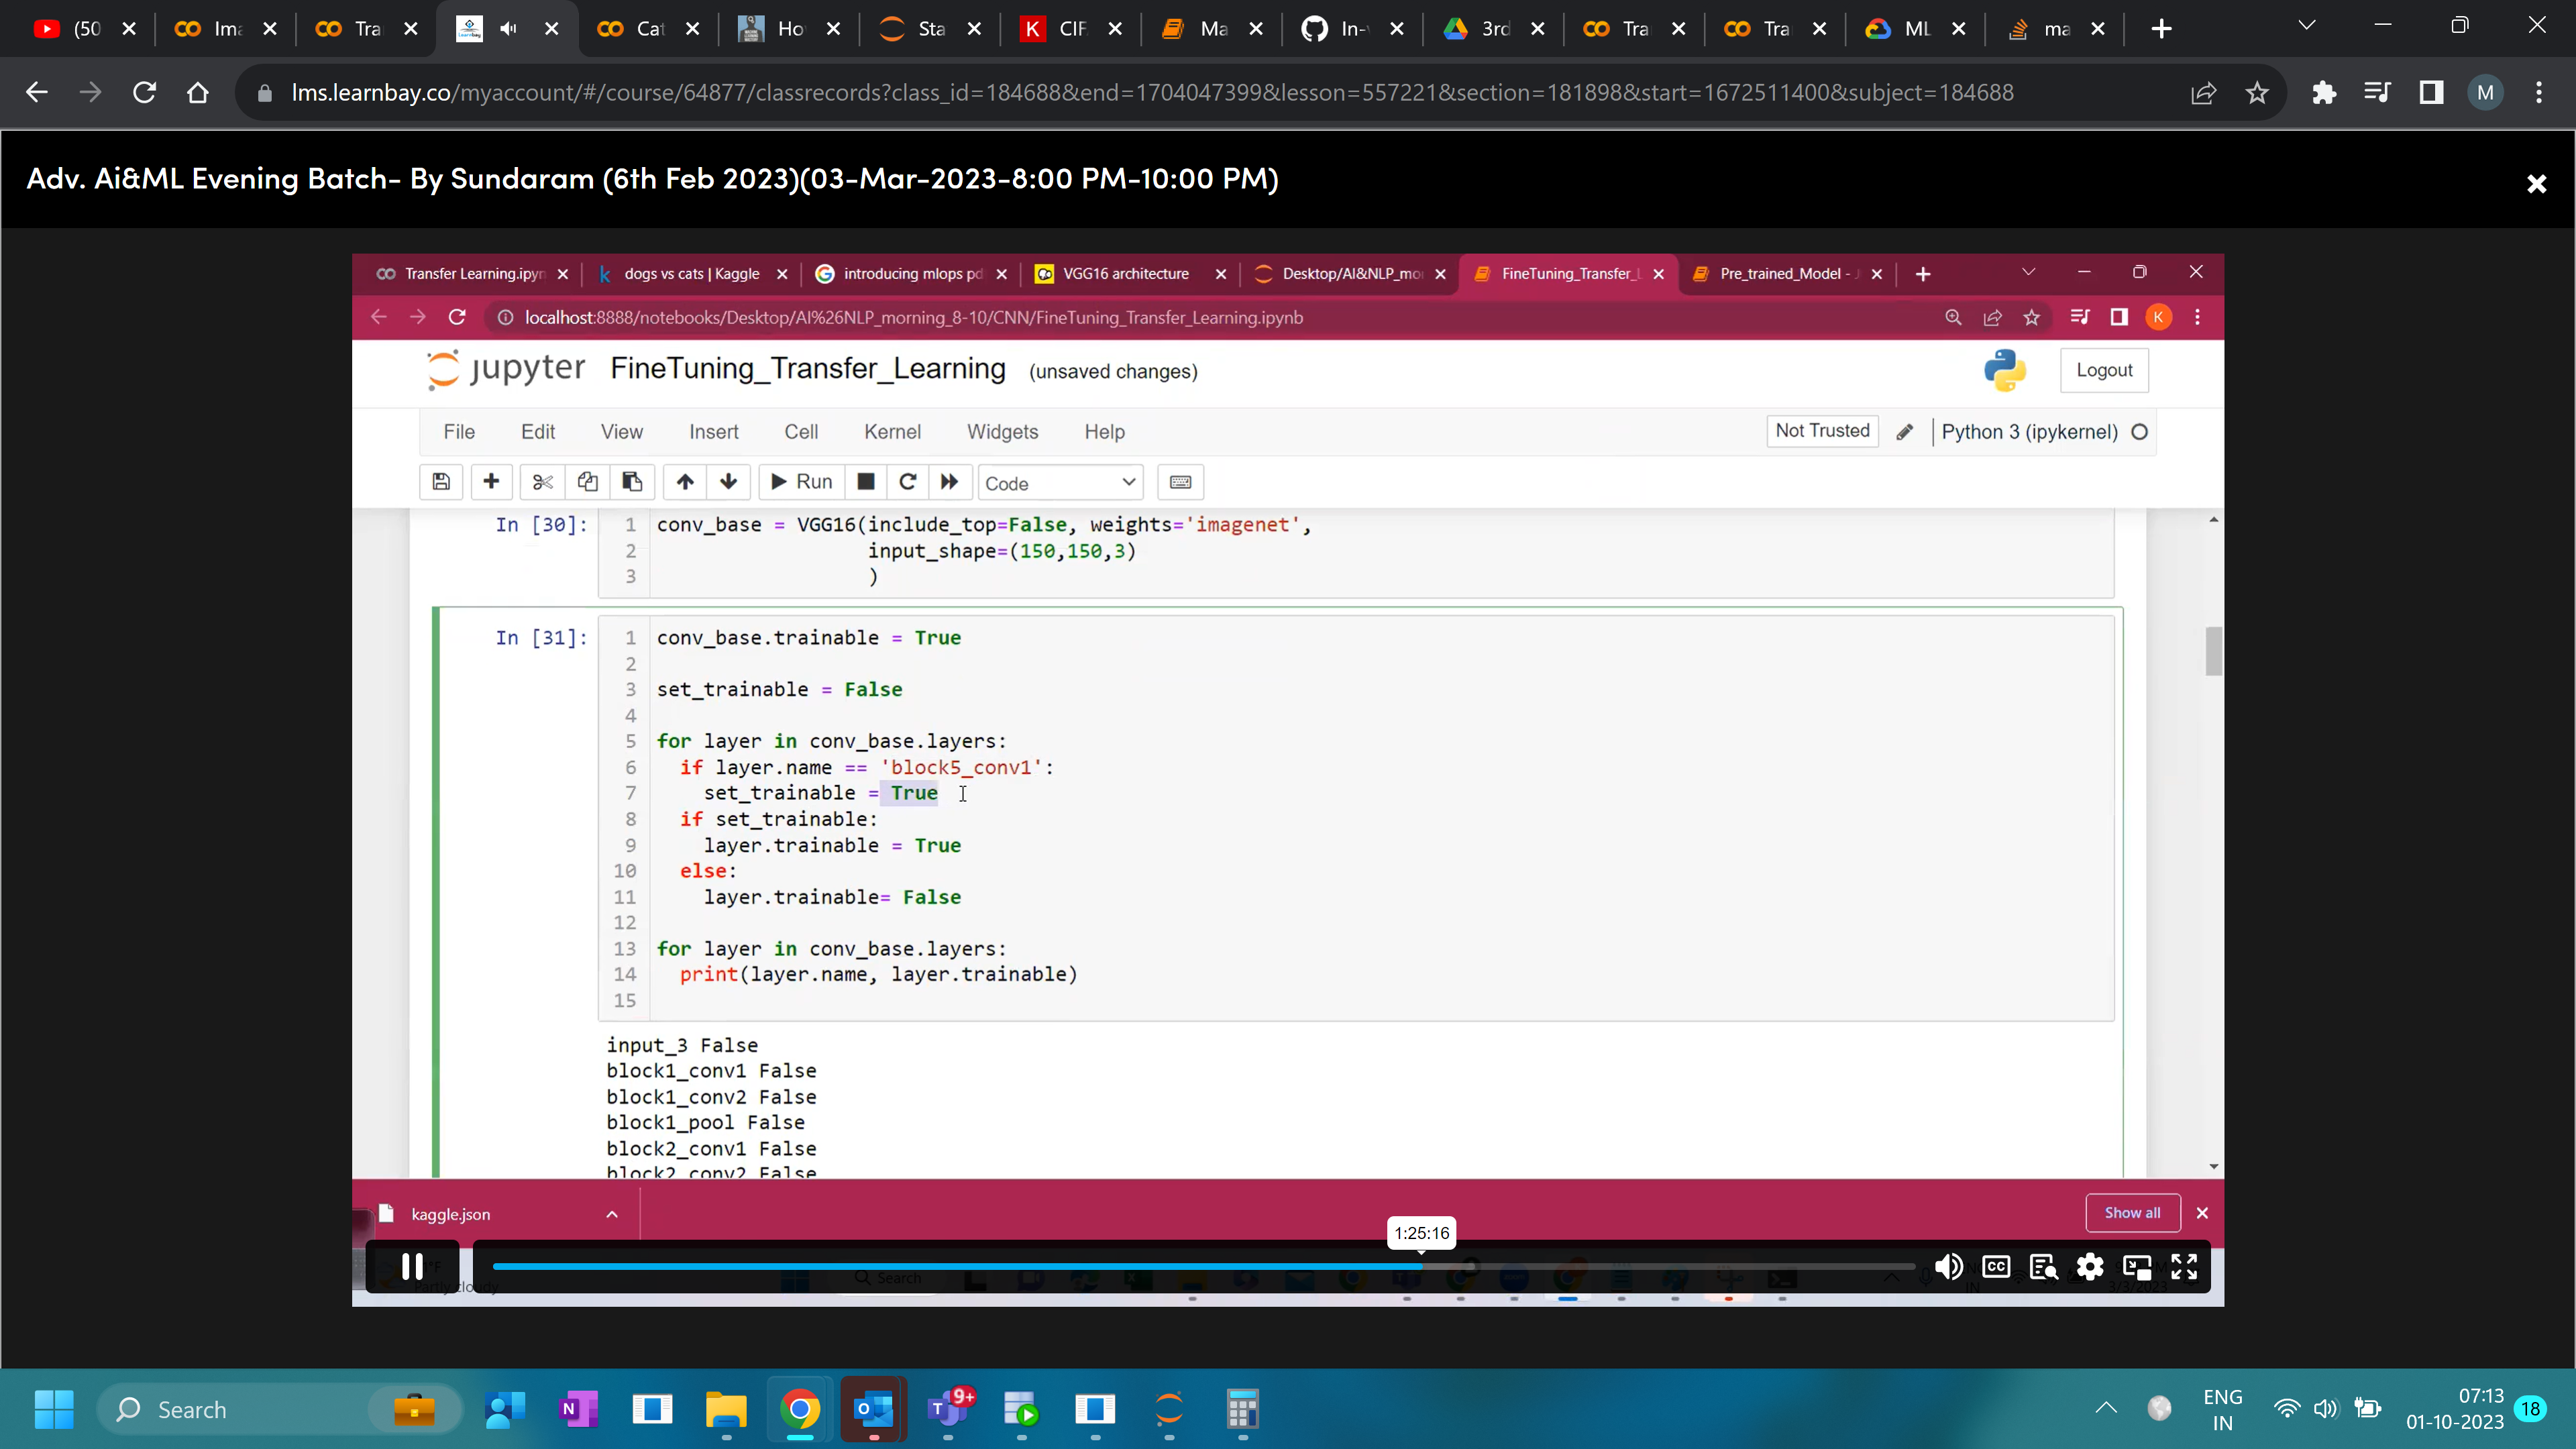